In [1]:
from pytfa.io.json import load_json_model
reduced_model = load_json_model('reduced_model_ETC_core_20240501-122843.json')

reduced_model.prepare()
reduced_model.convert(add_displacement=True)


In [ ]:
reduced_model.optimize()

,fluxes,reduced_costs
ACACt2m,-0.901961,None
ACONTm,12.803922,None
ADK3,1.901961,None
AKGDm,12.803922,None
ATPtm,171.392157,None
...,...,...
CYOR_u10mi,72.117647,None
NADH2_u10mi,52.313725,None
CYOOm2i,36.058824,None
cyt_atp2adp,171.490196,None


In [ ]:
reduced_model.delta_gstd.O2t

-1e-06 <= DGo_O2t <= 1e-06

In [ ]:
reduced_model.medium

{'EX_bhb_e': 1.0,
 'EX_hdca_e': 1.0,
 'EX_h_e': 200.0,
 'EX_h2o_e': 200.0,
 'EX_lac_L_e': 1.0,
 'EX_o2_e': 200.0,
 'EX_glc_D_e': 1.0}

In [ ]:
# Flux constraints for the core model 
RER = 0.8
o2_uptake = 2.0 * 0.8
co2_production = o2_uptake * RER 

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
reduced_model.reactions.EX_o2_e.bounds = (-o2_uptake, -o2_uptake)
# Constrain the RET to about 0.8 of the total glucose uptake
reduced_model.reactions.EX_co2_e.bounds = (co2_production, co2_production)
#reduced_model.reactions.CO2tm.bounds = (-10, -co2_production*0.5)
reduced_model.optimize()


#Add constraints for CO2 production in the core model of and glucose, lactate
glucose_direct_contribution = 0.04 / 6
lactate_direct_contribution = 0.24 / 3

reduced_model.reactions.EX_glc_D_e.bounds = (- co2_production * glucose_direct_contribution, -co2_production * glucose_direct_contribution)
reduced_model.reactions.EX_lac_L_e.bounds = (-co2_production * lactate_direct_contribution, -co2_production * lactate_direct_contribution)
reduced_model.optimize()

#minimize reduced_model.reactions.Htmi // minimal loss i.e. proton pumping loss
#reduced_model.optimize()

# Mitochondria release water 
#remove some unbalanced reactions
remove_reactions = ['r0377']
for reaction_id in remove_reactions:
    try:
        reduced_model.reactions.get_by_id(reaction_id).bounds = (0, 0)
    except KeyError:
        print(f'{reaction_id} not found')


r0377 not found


In [ ]:
reduced_model.reactions.H2Otm.reaction

'h2o_c <=> h2o_m'

In [ ]:
# Function to integrate metabolite concentrations
import numpy as np 
def set_concentration(model, metabolite_id, concentration, uncertainty=0.1, unit='mmol/L'):
    if unit == 'mmol/L':
        concentration = concentration / 1000
    else:
        raise ValueError('Unit not supported')

    metabolite = model.log_concentration.get_by_id(metabolite_id)
    var = metabolite.variable
    var.ub = np.log(concentration + concentration * uncertainty)
    var.lb = np.log(concentration - concentration * uncertainty)

In [ ]:
# Integrate serum metabolomics 

# Glucose concentration in serum
glucose_concentration = 5.5 # mmol/L 
# Lactate concentration in serum
lactate_concentration = 0.75 # mmol/L
# Fatty-acid concentration in serum
fatty_acid_concentration = 0.5 # mmol/L
# Ketone concentration in serum 
ketone_concentration = 0.1 # mmol/L

# O2 concentration in serum 90 mmHG -> to mmol/L
T = 273.15 + 37
o2_concentration = 1e3 * 90/ (62.36367*T)

# CO2 concentration in serum 40 mmHG -> to mmol/L
co2_concentration = 1e3 * 40/ (62.36367*T)

set_concentration(reduced_model, 'glc_D_e', glucose_concentration)
set_concentration(reduced_model, 'lac_L_e', lactate_concentration)
set_concentration(reduced_model, 'hdca_e', fatty_acid_concentration)
set_concentration(reduced_model, 'bhb_e', fatty_acid_concentration)
set_concentration(reduced_model, 'o2_e', o2_concentration)
set_concentration(reduced_model, 'co2_e', co2_concentration)

In [ ]:
# Run a flux analysis to see how constrain is the flux distribution
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')


2024-05-02 10:43:19,595 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
minimizing:   0%|          | 0/68 [00:00<?, ?it/s]

maximizing: 100%|██████████| 68/68 [00:03<00:00, 17.42it/s]


In [ ]:
# Remove the reactions that cannot carry flux
EPSILON = 1e-6  
reactions_to_remove = [r for r in reduced_model.reactions if FVA.loc[r.id, 'minimum'] >= -EPSILON and FVA.loc[r.id, 'maximum'] <= EPSILON ]
reduced_model.remove_reactions(reactions_to_remove)
reduced_model.repair()

metabolites_to_remove = [m for m in reduced_model.metabolites if len(m.reactions) == 0]
reduced_model.remove_metabolites(metabolites_to_remove)
reduced_model.repair()

In [ ]:
# Protons
for r in reduced_model.metabolites.h_c.reactions:
    print(r.id, r.reaction)



BHBtm bhb_c + h_c <=> bhb_m + h_m
AACOAT acac_c + atp_c + coa_c --> aacoa_c + amp_c + h_c + ppi_c
L_LACt2r h_e + lac_L_e <=> h_c + lac_L_c
cyt_atp2adp atp_c + h2o_c --> adp_c + h_c + pi_c
PiC h_c + pi_c --> h_m + pi_m
LDH_L lac_L_c + nad_c <=> 2.0 h_c + nadh_c + pyr_c
PYK adp_c + h_c + pep_c --> atp_c + pyr_c
PPA h2o_c + ppi_c --> h_c + 2.0 pi_c
PALFATPtc atp_c + coa_c + hdca_e --> amp_c + h_c + pmtcoa_c + ppi_c
L_LACtm h_c + lac_L_c --> h_m + lac_L_m
ACACt2m acac_c + h_c <=> acac_m + h_m
HEX1 atp_c + glc_D_c --> adp_c + g6p_c + h_c
ADK1 amp_c + atp_c + h_c <=> 2.0 adp_c
ADK3 amp_c + gtp_c + h_c <=> adp_c + gdp_c
PFK atp_c + f6p_c --> adp_c + fdp_c + h_c
BHBt bhb_e + h_e <=> bhb_c + h_c
GAPD g3p_c + nad_c + pi_c <=> 13dpg_c + 2.0 h_c + nadh_c
The h_e <=> h_c


In [ ]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

2024-05-02 10:43:27,603 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 68/68 [00:03<00:00, 19.93it/s]


In [ ]:
FVA

,minimum,maximum,range,mid
ACACt2m,-0.066560,-0.066560,5.551115e-16,-0.066560
ACONTm,0.580267,0.580267,0.000000e+00,0.580267
ADK3,0.107520,0.580267,4.727467e-01,0.343893
AKGDm,0.580267,0.580267,0.000000e+00,0.580267
ATPtm,7.133013,7.605760,4.727467e-01,7.369387
...,...,...,...,...
CYOR_u10mi,3.200000,3.200000,0.000000e+00,3.200000
NADH2_u10mi,2.333013,2.333013,1.332268e-15,2.333013
CYOOm2i,1.600000,1.600000,0.000000e+00,1.600000
cyt_atp2adp,7.515307,7.515307,8.881784e-16,7.515307


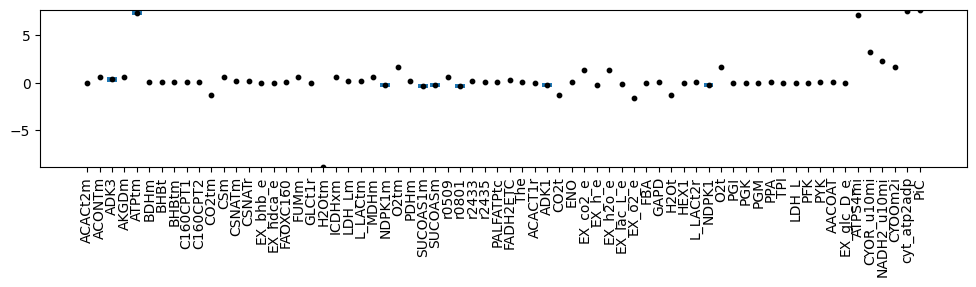

In [ ]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

f = plt.figure(figsize=(10, 3))
plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)

# from cobra.flux_analysis.parsimonious import optimize_minimal_flux
# reduced_model.objective = reduced_model.problem.Objective(reduced_model.reactions.cyt_atp2adp.forward_variable, direction='max')
# sol = optimize_minimal_flux(reduced_model)
# plt.scatter(sol.fluxes.index, sol.fluxes, color='r', s=10)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [ ]:
reduced_model.objective = reduced_model.problem.Objective(reduced_model.reactions.cyt_atp2adp.forward_variable, direction='max')


In [ ]:
FVA['mid'].to_csv('fluxes.csv')

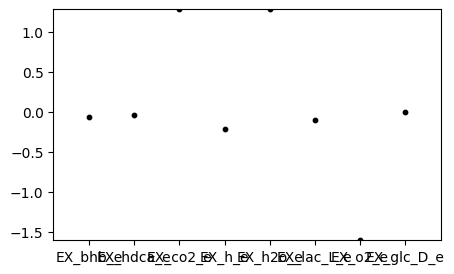

In [ ]:
# Plot FVA of only exchage reactions
plt.figure(figsize=(5, 3))
#exchange_reactions = [r.id for r in reduced_model.metabolites.h_c.reactions]
exchange_reactions = [r.id for r in reduced_model.boundary]

FVA_exchange = FVA.loc[exchange_reactions]

FVA_exchange['range'] = FVA_exchange.maximum - FVA_exchange.minimum
FVA_exchange['mid'] = (FVA_exchange.maximum + FVA_exchange.minimum) / 2
plt.bar(FVA_exchange.index, FVA_exchange.range, bottom=FVA_exchange.minimum)
plt.scatter(FVA_exchange.index, FVA_exchange.mid, color='k', s=10)


In [ ]:
# Print all reversible reaction formulas i.e. FVA (min < 0, max > 0)
for rxn in reduced_model.reactions:
    if FVA.loc[rxn.id].minimum < 0 and FVA.loc[rxn.id].maximum > 0:
        print(rxn.id, rxn.reaction)

In [ ]:
# Minimize dissipation of energy
# dissipation is C + v_bd * log(x_bd)
exchange_reactions = [r.id for r in reduced_model.boundary]
exchange_metabolites = [m.id for r in reduced_model.boundary for m in r.metabolites]

exchange_metabolites, exchange_reactions

(['bhb_e', 'hdca_e', 'co2_e', 'h_e', 'h2o_e', 'lac_L_e', 'o2_e', 'glc_D_e'],
 ['EX_bhb_e',
  'EX_hdca_e',
  'EX_co2_e',
  'EX_h_e',
  'EX_h2o_e',
  'EX_lac_L_e',
  'EX_o2_e',
  'EX_glc_D_e'])

2024-05-02 10:43:36,519 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 76/76 [00:05<00:00, 13.33it/s]


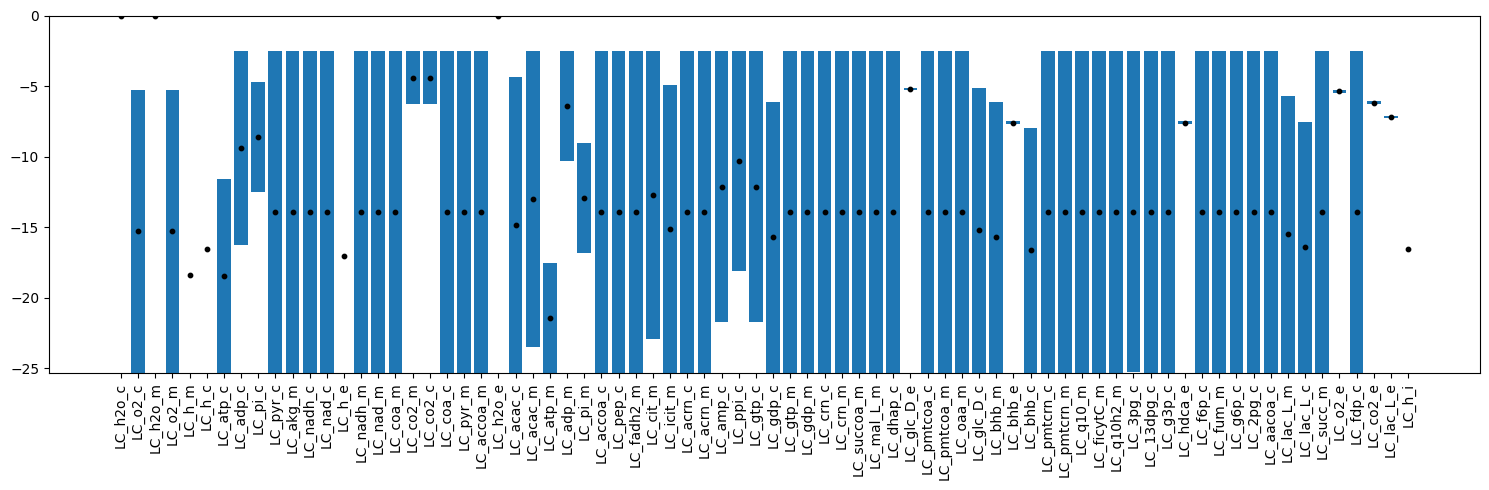

In [ ]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Concentration of metabolites
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))
TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2
plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)
plt.scatter(TVA.index, TVA.mid, color='k', s=10)


plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [ ]:
# This as an attempt not really makes sense
# dissipation = sum([ r.variable * reduced_model.reactions.get_by_id(r.id).reverse_variable 
#                - r.variable * reduced_model.reactions.get_by_id(r.id).forward_variable 
#                for r in reduced_model.delta_g])

# # Objective function
# reduced_model.objective = reduced_model.problem.Objective(dissipation, direction='min')

# reduced_model.solver.problem.parameters.optimalitytarget.set(3)

# reduced_model.optimize()

G_O2tm: -1.0*DG_O2tm + 1.0*DGo_O2tm - 0.592089376625*LC_o2_c + 0.592089376625*LC_o2_m